In [1]:
#### Importar librerias necesarias  ###

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from sklearn.linear_model import Ridge, RidgeCV
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_absolute_percentage_error, f1_score
from sklearn.preprocessing import LabelEncoder
import sqlite3 as sql
from sklearn.linear_model import LogisticRegression
from sklearn import svm, tree, metrics
from sklearn.ensemble import RandomForestClassifier ##Ensamble con bagging
from sklearn.ensemble import GradientBoostingClassifier ###Ensamble boosting
from sklearn.model_selection import cross_val_predict, cross_val_score, cross_validate, train_test_split, RandomizedSearchCV
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import GridSearchCV
import joblib  ### para guardar modelos
import a_funciones as funciones
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import openpyxl
%matplotlib inline

In [2]:
##Se cargan las bases de datos almacenadas en el github
df_data= 'https://raw.githubusercontent.com/GabrielaCuervoR/Analitica3/main/Data/general_data.csv'
df_retiros= 'https://raw.githubusercontent.com/GabrielaCuervoR/Analitica3/main/Data/retirement_info.csv'
df_employee= 'https://raw.githubusercontent.com/GabrielaCuervoR/Analitica3/main/Data/employee_survey_data.csv'
df_manager= 'https://raw.githubusercontent.com/GabrielaCuervoR/Analitica3/main/Data/manager_survey_data.csv'

In [3]:
##Se leen la base de datos con la información arreglada
df_data=pd.read_csv(df_data, sep= ';' )
df_retiros=pd.read_csv(df_retiros, sep=';')
df_employee=pd.read_csv(df_employee)
df_manager=pd.read_csv(df_manager)

In [4]:
conn= sql.connect("db_empleados") ## Con este comando se crea la base de datos o si ya existe se conecta

df_employee.to_sql("employee_survey_data",conn,if_exists="replace")
df_data.to_sql("general_data",conn,if_exists="replace")
df_manager.to_sql("manager_survey_data",conn,if_exists="replace")
df_retiros.to_sql("retirement_info",conn,if_exists="replace")

711

In [5]:
cur= conn.cursor()
funciones.ejecutar_sql('preprocesamiento.sql', cur)

In [6]:
df2=pd.read_sql("select * from base_nueva", conn)
df2 = df2.drop(columns=['index'], axis=1)##Se elimina la columna index que por defecto la sube sql

In [7]:
df2.isnull().sum() #Mirar la cantidad de nulos de cada variable

### imputación y eliminación de varibles
# ==============================================================================
list_cat=['EnvironmentSatisfaction','JobSatisfaction','WorkLifeBalance']
list_num=['NumCompaniesWorked','TotalWorkingYears']

funciones.imputar_fc(df2,list_cat)
funciones.imputar_fn(df2,list_num)
df2 = df2.drop(['Over18','EmployeeCount'], axis = 1) #eliminación de variables de una sola categoria

In [8]:
df2.isnull().sum() #se verifica que quede completa

### Transformación de variable objetivo
# ==============================================================================
df2['Attrition'] = df2['Attrition'].fillna('No') #se rellenan los nulos de la variable objetivo por No
df2['Attrition'].value_counts()

#### preparación de los datos
# ==============================================================================
y = df2.Attrition ##Variable Objetivo
le = LabelEncoder()
y = le.fit_transform(y)

print(y[0:5])

print(le.classes_)

df2['Attrition'] = y


[0 1 0 0 0]
['No' 'Yes']


In [9]:
df2.EnvironmentSatisfaction = df2.EnvironmentSatisfaction.astype(int)
df2.JobSatisfaction  = df2.JobSatisfaction.astype(int)
df2.WorkLifeBalance = df2.WorkLifeBalance.astype(int)
df2.NumCompaniesWorked = df2.NumCompaniesWorked.astype(int)
df2.TotalWorkingYears = df2.TotalWorkingYears.astype(int)

#### Variables dummis
# ==============================================================================
df3=df2.copy()
list_dummies=['BusinessTravel','Department','EducationField','Gender','JobRole','MaritalStatus']
df_dummies=pd.get_dummies(df3,columns=list_dummies)

y=df_dummies.Attrition
X1= df_dummies.loc[:,~df_dummies.columns.isin(['Attrition','EmployeeID'])]
scaler=StandardScaler()
scaler.fit(X1)
X2=scaler.transform(X1)
X=pd.DataFrame(X2,columns=X1.columns)


In [10]:
m_log = LogisticRegression(max_iter=1000,random_state=42, class_weight='balanced')
m_rf= RandomForestClassifier(random_state=42, class_weight='balanced')
m_tc = tree.DecisionTreeClassifier(random_state=42, class_weight='balanced')
m_gbt=GradientBoostingClassifier(random_state=42)


modelos=list([m_log, m_rf, m_tc, m_gbt])

In [11]:
### selección de variables
# ==============================================================================
var_names= funciones.sel_variables(modelos,X,y,threshold="2.35*mean") #se decide usar el 2.35 mean para tener solo 10 variables en el modelo
var_names.shape

modelo=modelos[0]
modelo.fit(X,y)

X2=X[var_names] ### matriz con variables seleccionadas
X2.info()

acc_df = funciones.medir_modelos(modelos,"f1",X,y,2) ## base con todas las variables
acc_varsel= funciones.medir_modelos(modelos,"f1",X2,y,2) ### base con variables seleccionadas

acc=pd.concat([acc_df,acc_varsel],axis=1)
acc.columns=['log', 'rf', 'tc','gbt',
       'log_sel','rf_sel', 'tc_sel','gb_sel']

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4410 entries, 0 to 4409
Data columns (total 12 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Age                      4410 non-null   float64
 1   DistanceFromHome         4410 non-null   float64
 2   JobSatisfaction          4410 non-null   float64
 3   MaritalStatus_Single     4410 non-null   float64
 4   MonthlyIncome            4410 non-null   float64
 5   NumCompaniesWorked       4410 non-null   float64
 6   PercentSalaryHike        4410 non-null   float64
 7   TotalWorkingYears        4410 non-null   float64
 8   TrainingTimesLastYear    4410 non-null   float64
 9   YearsAtCompany           4410 non-null   float64
 10  YearsSinceLastPromotion  4410 non-null   float64
 11  YearsWithCurrManager     4410 non-null   float64
dtypes: float64(12)
memory usage: 413.6 KB


In [12]:
##### afinamiento de hiperparametros
# ==============================================================================
# Separación en conjuntos de entrenamiento y validación con 80% de muestras para entrenamiento
X_train, X_test, y_train, y_test = train_test_split(X2, y, test_size=0.2, random_state=42)

# Definición de cuadricula de hiperparametros
parameters = {'n_estimators': [20,40,80,100,150],
              'max_depth':[10,12,14,15,16],
              'max_leaf_nodes': [50,70,100, 300]}


In [24]:
#Definición del modelo
# ==============================================================================
rfc = RandomForestClassifier(random_state=42, class_weight='balanced')

grid_search = GridSearchCV(rfc, parameters, cv=5, scoring='f1', n_jobs=-1)
grid_result = grid_search.fit(X_train, y_train)

print('Best Params: ', grid_result.best_params_)
print('Best Score: ', grid_result.best_score_)

bestModel_rfc=grid_result.best_estimator_
print("F1:{:.2f}".format(bestModel_rfc.score(X_test,y_test)))


Best Params:  {'max_depth': 14, 'max_leaf_nodes': 300, 'n_estimators': 150}
Best Score:  0.929541966158656
F1:0.99


In [14]:
#bestModel_rfc=bestModel_rfc.fit(X_train, y_train)

In [25]:
importancia = bestModel_rfc.feature_importances_
importancia = pd.DataFrame(importancia, columns=['Importancia'])

In [26]:
X3 = pd.DataFrame(X2.columns, columns=['Variables'])

In [27]:

# Concatenar las Series al DataFrame X2
X2_con_importancias = pd.concat([X3, importancia], axis=1)

In [28]:
X2_con_importancias.sort_values(by=['Importancia'], ascending=False)

,Variables,Importancia
4,MonthlyIncome,0.131888
0,Age,0.125753
7,TotalWorkingYears,0.107202
1,DistanceFromHome,0.096340
9,YearsAtCompany,0.090228
6,PercentSalaryHike,0.081362
11,YearsWithCurrManager,0.074915
5,NumCompaniesWorked,0.066837
8,TrainingTimesLastYear,0.062697
2,JobSatisfaction,0.062092


Train - Accuracy : 1.0
Train - classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      2958
           1       1.00      1.00      1.00       570

    accuracy                           1.00      3528
   macro avg       1.00      1.00      1.00      3528
weighted avg       1.00      1.00      1.00      3528

Test - Accuracy : 0.9920634920634921
Test - classification report :               precision    recall  f1-score   support

           0       0.99      1.00      1.00       741
           1       1.00      0.95      0.97       141

    accuracy                           0.99       882
   macro avg       1.00      0.98      0.98       882
weighted avg       0.99      0.99      0.99       882



<Figure size 1100x1100 with 0 Axes>

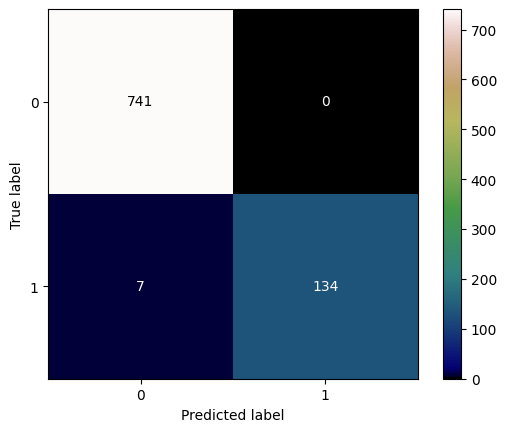

In [29]:
# Métricas de desempeño
# ==============================================================================
print ("Train - Accuracy :", metrics.accuracy_score(y_train, bestModel_rfc.predict(X_train)))
print ("Train - classification report:\n", metrics.classification_report(y_train, bestModel_rfc.predict(X_train)))
print ("Test - Accuracy :", metrics.accuracy_score(y_test, bestModel_rfc.predict(X_test)))
print ("Test - classification report :", metrics.classification_report(y_test, bestModel_rfc.predict(X_test)))


# Matriz de confusión
# ==============================================================================
y_hat=bestModel_rfc.predict(X_test)
fig = plt.figure(figsize=(11,11))
cm = confusion_matrix(y_test,y_hat, labels=bestModel_rfc.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels=bestModel_rfc.classes_)
disp.plot(cmap='gist_earth')
plt.show()


In [20]:
importancia.to_excel("feature_importances.xlsx")

In [30]:
joblib.dump(bestModel_rfc, "bestModel_rfc.pkl") ##  Modelo final con variables seleccionadas
joblib.dump(m_rf, "m_rf.pkl") ## Modelo con todas las variables
joblib.dump(list_cat, "list_cat.pkl") ### para realizar imputacion variables categóricas
joblib.dump(list_num, "list_num.pkl") ### para realizar imputacion variables numéricas
joblib.dump(list_dummies, "list_dummies.pkl")  ### para convertir a dummies
joblib.dump(var_names, "var_names.pkl")  ### para variables con que se entrena modelo
joblib.dump(scaler, "scaler.pkl") ##


bestModel_rfc = joblib.load("bestModel_rfc.pkl")
m_rf = joblib.load("m_rf.pkl")
list_cat=joblib.load("list_cat.pkl")
list_num=joblib.load("list_num.pkl")
list_dummies=joblib.load("list_dummies.pkl")
var_names=joblib.load("var_names.pkl")
scaler=joblib.load("scaler.pkl")


In [33]:
def preparar_datos (df):



  #######Cargar y procesar nuevos datos ######


  #### Cargar modelo y listas


  list_cat=joblib.load("list_cat.pkl")
  list_num=joblib.load("list_num.pkl")
  list_dummies=joblib.load("list_dummies.pkl")
  var_names=joblib.load("var_names.pkl")
  scaler=joblib.load( "scaler.pkl")

  ####Ejecutar funciones de transformaciones

  df=funciones.imputar_fc(df,list_cat)
  df=funciones.imputar_fn(df,list_num)
  df_dummies=pd.get_dummies(df,columns=list_dummies)
  df_dummies= df_dummies.loc[:,~df_dummies.columns.isin(['Attrition','EmployeeID'])]
  X2=scaler.transform(df_dummies)
  X=pd.DataFrame(X2,columns=df_dummies.columns)
  X=X[var_names]




  return X

In [46]:

import pandas as pd ### para manejo de datos
import sqlite3 as sql
import joblib
import openpyxl ## para exportar a excel
import numpy as np


###### el despliegue consiste en dejar todo el código listo para una ejecucion automática en el periodo definido:
###### en este caso se ejecutara el proceso de entrenamiento y prediccion anualmente.
if __name__=="__main__":


  ### conectarse a la base de datos ###
  conn=sql.connect("db_empleados")
  cur=conn.cursor()

  ### Ejecutar sql de preprocesamiento inicial y juntarlo
  #### con base de preprocesamiento con la que se entrenó para evitar perdida de variables por conversión a dummies

  funciones.ejecutar_sql('preprocesamiento.sql',cur) ### con las fechas actualizadas explicativas 2023- predecir 2024
  df=pd.read_sql('''select  * from base_nueva''',conn)
  df = df.drop(['Over18','EmployeeCount','index'], axis = 1) #eliminación de variables de una sola categoria

  ####Otras transformaciones en python (imputación, dummies y seleccion de variables)
  df_t= preparar_datos(df)


  ##Cargar modelo y predecir
  bestModel_rfc = joblib.load("bestModel_rfc.pkl")
  predicciones=bestModel_rfc.predict(df_t)
  pd_pred=pd.DataFrame(predicciones, columns=['pred_2017'])


  ###Crear base con predicciones ####

  perf_pred=pd.concat([df['EmployeeID'],df_t,pd_pred],axis=1)

  ####LLevar a BD para despliegue
  perf_pred.loc[:,['EmployeeID', 'pred_2017']].to_sql("perf_pred",conn,if_exists="replace") ## llevar predicciones a BD con ID Empleados


  ####ver_predicciones_bajas ###
  emp_pred_bajo=perf_pred.sort_values(by=["pred_2017"],ascending=True).head(10)

  emp_pred_bajo.set_index('EmployeeID', inplace=True)
  pred=emp_pred_bajo.T

  importancia1 = bestModel_rfc.feature_importances_   #importancia de las variables seleccionadas
  importancia1 = pd.DataFrame(importancia1, columns=['Importancia'])
  X3 = pd.DataFrame(X2.columns, columns=['Variables'])
  # Concatenar las Series al DataFrame X2
  variables_con_importancias = pd.concat([X3, importancia1], axis=1)
  variables_con_importancias.to_excel("variables_con_importancias.xlsx") ### exportar importancia de variables para análisis personalizado

